## Full MobileNetV2 + SVM Code (FAST + HIGH ACCURACY)

In [2]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [4]:
!unzip archive.zip -d brain_tumor_dataset

Archive:  archive.zip
  inflating: brain_tumor_dataset/Testing/glioma/Te-glTr_0000.jpg  
  inflating: brain_tumor_dataset/Testing/glioma/Te-glTr_0001.jpg  
  inflating: brain_tumor_dataset/Testing/glioma/Te-glTr_0002.jpg  
  inflating: brain_tumor_dataset/Testing/glioma/Te-glTr_0003.jpg  
  inflating: brain_tumor_dataset/Testing/glioma/Te-glTr_0004.jpg  
  inflating: brain_tumor_dataset/Testing/glioma/Te-glTr_0005.jpg  
  inflating: brain_tumor_dataset/Testing/glioma/Te-glTr_0006.jpg  
  inflating: brain_tumor_dataset/Testing/glioma/Te-glTr_0007.jpg  
  inflating: brain_tumor_dataset/Testing/glioma/Te-glTr_0008.jpg  
  inflating: brain_tumor_dataset/Testing/glioma/Te-glTr_0009.jpg  
  inflating: brain_tumor_dataset/Testing/glioma/Te-gl_0010.jpg  
  inflating: brain_tumor_dataset/Testing/glioma/Te-gl_0011.jpg  
  inflating: brain_tumor_dataset/Testing/glioma/Te-gl_0012.jpg  
  inflating: brain_tumor_dataset/Testing/glioma/Te-gl_0013.jpg  
  inflating: brain_tumor_dataset/Testing/glioma/

In [6]:
import os 
print(os.listdir('brain_tumor_dataset'))

['Training', 'Testing']


In [8]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
# ================================================================
# 1. IMPORT LIBRARIES
# ================================================================
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [12]:
# ================================================================
# 2. PATHS & HYPERPARAMETERS
# ================================================================
train_path = 'brain_tumor_dataset/Training'
test_path = 'brain_tumor_dataset/Testing'

img_size = (180, 180)       # Faster, very good for MobileNetV2
batch_size = 16
epochs = 15                 # MobileNetV2 trains fast
num_classes = len(os.listdir(train_path))


In [14]:
# ================================================================
# 3. DATA GENERATORS
# ================================================================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [16]:
# ================================================================
# 4. LOAD MobileNetV2 + UNFREEZE LAST 6 LAYERS
# ================================================================
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(180,180,3))

for layer in base_model.layers[:-6]:
    layer.trainable = False

In [18]:
# ================================================================
# 5. ADD CUSTOM CLASSIFIER
# ================================================================
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
# ================================================================
# 6. CALLBACKS
# ================================================================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2),
    ModelCheckpoint('best_mobilenetv2.keras', monitor='val_accuracy', save_best_only=True)
]

In [22]:
# ================================================================
# 7. TRAIN MobileNetV2 (FAST)
# ================================================================
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 77ms/step - accuracy: 0.7258 - loss: 0.7120 - val_accuracy: 0.7788 - val_loss: 0.6559 - learning_rate: 1.0000e-04
Epoch 2/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.8695 - loss: 0.3573 - val_accuracy: 0.8604 - val_loss: 0.3948 - learning_rate: 1.0000e-04
Epoch 3/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.9035 - loss: 0.2691 - val_accuracy: 0.8810 - val_loss: 0.3576 - learning_rate: 1.0000e-04
Epoch 4/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step - accuracy: 0.9178 - loss: 0.2208 - val_accuracy: 0.8856 - val_loss: 0.3391 - learning_rate: 1.0000e-04
Epoch 5/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step - accuracy: 0.9080 - loss: 0.2293 - val_accuracy: 0.8665 - val_loss: 0.3773 - learning_rate: 1.0000e-04
Epoch 6/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - accuracy: 0.9248 - loss: 0.1980 - val_accuracy: 0.8833 - val_loss: 0.3534 - learning_rate: 1.0000e-04
Epoch 7/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/ste

In [24]:
# ================================================================
# 8. EVALUATE BASE SOFTMAX MODEL
# ================================================================
loss, acc = model.evaluate(test_gen)
print(f"\nSoftmax Test Accuracy: {acc:.4f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9423 - loss: 0.1444

Softmax Test Accuracy: 0.9413


In [26]:
# ================================================================
# 9. FEATURE EXTRACTION MODEL
# ================================================================
feature_extractor = models.Model(
    inputs=model.input,
    outputs=model.layers[-2].output   # Dense(128) layer output
)

feature_datagen = ImageDataGenerator(rescale=1./255)

train_feature_gen = feature_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_feature_gen = feature_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [28]:
# ================================================================
# 10. FEATURE EXTRACTION FUNCTION
# ================================================================
def extract_features(generator, count):
    features, labels = [], []
    steps = count // generator.batch_size

    for _ in tqdm(range(steps)):
        x_batch, y_batch = next(generator)
        f = feature_extractor.predict(x_batch)
        features.append(f)
        labels.append(np.argmax(y_batch, axis=1))

    return np.vstack(features), np.concatenate(labels)

In [30]:

# ================================================================
# 11. EXTRACT FEATURES
# ================================================================
X_train, y_train = extract_features(train_feature_gen, train_gen.samples)
X_test, y_test = extract_features(test_feature_gen, test_gen.samples)

  0%|                                                   | 0/357 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


  0%|                                           | 1/357 [00:00<02:28,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  1%|▎                                          | 3/357 [00:00<00:58,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  1%|▌                                          | 5/357 [00:00<00:42,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  2%|▊                                          | 7/357 [00:00<00:35,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  3%|█                                          | 9/357 [00:01<00:32, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  3%|█▎                                        | 11/357 [00:01<00:29, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  4%|█▌                                        | 13/357 [00:01<00:28, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  4%|█▊                                        | 15/357 [00:01<00:27, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  5%|██                                        | 17/357 [00:01<00:27, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  5%|██▏                                       | 19/357 [00:01<00:27, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  6%|██▍                                       | 21/357 [00:01<00:26, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  6%|██▋                                       | 23/357 [00:02<00:26, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  7%|██▉                                       | 25/357 [00:02<00:26, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  8%|███▏                                      | 27/357 [00:02<00:25, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  8%|███▍                                      | 29/357 [00:02<00:25, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  9%|███▋                                      | 31/357 [00:02<00:25, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  9%|███▉                                      | 33/357 [00:02<00:25, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 10%|████                                      | 35/357 [00:03<00:25, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 10%|████▎                                     | 37/357 [00:03<00:25, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 11%|████▌                                     | 39/357 [00:03<00:25, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 11%|████▊                                     | 41/357 [00:03<00:25, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 12%|█████                                     | 43/357 [00:03<00:25, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 13%|█████▎                                    | 45/357 [00:03<00:25, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 13%|█████▌                                    | 47/357 [00:04<00:25, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 14%|█████▊                                    | 49/357 [00:04<00:25, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 14%|██████                                    | 51/357 [00:04<00:24, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 15%|██████▏                                   | 53/357 [00:04<00:24, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 15%|██████▍                                   | 55/357 [00:04<00:23, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 16%|██████▋                                   | 57/357 [00:04<00:23, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 17%|██████▉                                   | 59/357 [00:04<00:23, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 17%|███████▏                                  | 61/357 [00:05<00:23, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 18%|███████▍                                  | 63/357 [00:05<00:23, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 18%|███████▋                                  | 65/357 [00:05<00:24, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 19%|███████▉                                  | 67/357 [00:05<00:24, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 19%|████████                                  | 69/357 [00:05<00:23, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 20%|████████▎                                 | 71/357 [00:05<00:23, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 20%|████████▌                                 | 73/357 [00:06<00:22, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 21%|████████▊                                 | 75/357 [00:06<00:22, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 22%|█████████                                 | 77/357 [00:06<00:22, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 22%|█████████▎                                | 79/357 [00:06<00:22, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 23%|█████████▌                                | 81/357 [00:06<00:21, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 23%|█████████▊                                | 83/357 [00:06<00:21, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 24%|██████████                                | 85/357 [00:07<00:21, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 24%|██████████▏                               | 87/357 [00:07<00:21, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 25%|██████████▍                               | 89/357 [00:07<00:21, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 25%|██████████▋                               | 91/357 [00:07<00:21, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 26%|██████████▉                               | 93/357 [00:07<00:21, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 27%|███████████▏                              | 95/357 [00:07<00:20, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 27%|███████████▍                              | 97/357 [00:08<00:21, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 28%|███████████▋                              | 99/357 [00:08<00:21, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 28%|███████████▌                             | 101/357 [00:08<00:20, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 29%|███████████▊                             | 103/357 [00:08<00:20, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 29%|████████████                             | 105/357 [00:08<00:19, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 30%|████████████▎                            | 107/357 [00:08<00:19, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 31%|████████████▌                            | 109/357 [00:09<00:19, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 31%|████████████▋                            | 111/357 [00:09<00:18, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 32%|████████████▉                            | 113/357 [00:09<00:18, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 32%|█████████████▏                           | 115/357 [00:09<00:18, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 33%|█████████████▍                           | 117/357 [00:09<00:18, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 33%|█████████████▋                           | 119/357 [00:09<00:18, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 34%|█████████████▉                           | 121/357 [00:09<00:18, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 34%|██████████████▏                          | 123/357 [00:10<00:18, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 35%|██████████████▎                          | 125/357 [00:10<00:17, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 36%|██████████████▌                          | 127/357 [00:10<00:18, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 36%|██████████████▊                          | 129/357 [00:10<00:17, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 37%|███████████████                          | 131/357 [00:10<00:17, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 37%|███████████████▎                         | 133/357 [00:10<00:17, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 38%|███████████████▌                         | 135/357 [00:10<00:16, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 38%|███████████████▋                         | 137/357 [00:11<00:16, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 39%|███████████████▉                         | 139/357 [00:11<00:16, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 39%|████████████████▏                        | 141/357 [00:11<00:16, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 40%|████████████████▍                        | 143/357 [00:11<00:16, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 41%|████████████████▋                        | 145/357 [00:11<00:15, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 41%|████████████████▉                        | 147/357 [00:11<00:15, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 42%|█████████████████                        | 149/357 [00:12<00:15, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 42%|█████████████████▎                       | 151/357 [00:12<00:15, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 43%|█████████████████▌                       | 153/357 [00:12<00:15, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 43%|█████████████████▊                       | 155/357 [00:12<00:15, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 44%|██████████████████                       | 157/357 [00:12<00:15, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 45%|██████████████████▎                      | 159/357 [00:12<00:15, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 45%|██████████████████▍                      | 161/357 [00:13<00:15, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 46%|██████████████████▋                      | 163/357 [00:13<00:15, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 46%|██████████████████▉                      | 165/357 [00:13<00:15, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 47%|███████████████████▏                     | 167/357 [00:13<00:15, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 47%|███████████████████▍                     | 169/357 [00:13<00:15, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 48%|███████████████████▋                     | 171/357 [00:13<00:15, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 48%|███████████████████▊                     | 173/357 [00:14<00:15, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 49%|████████████████████                     | 175/357 [00:14<00:16, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 50%|████████████████████▎                    | 177/357 [00:14<00:16, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 50%|████████████████████▌                    | 179/357 [00:14<00:15, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 51%|████████████████████▊                    | 181/357 [00:14<00:15, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 51%|█████████████████████                    | 183/357 [00:14<00:15, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 52%|█████████████████████▏                   | 185/357 [00:15<00:14, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 52%|█████████████████████▍                   | 187/357 [00:15<00:14, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 53%|█████████████████████▋                   | 189/357 [00:15<00:13, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 54%|█████████████████████▉                   | 191/357 [00:15<00:13, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 54%|██████████████████████▏                  | 193/357 [00:15<00:12, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 55%|██████████████████████▍                  | 195/357 [00:15<00:12, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 55%|██████████████████████▌                  | 197/357 [00:15<00:12, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 56%|██████████████████████▊                  | 199/357 [00:16<00:12, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 56%|███████████████████████                  | 201/357 [00:16<00:12, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 57%|███████████████████████▎                 | 203/357 [00:16<00:11, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 57%|███████████████████████▌                 | 205/357 [00:16<00:11, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 58%|███████████████████████▊                 | 207/357 [00:16<00:11, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 59%|████████████████████████                 | 209/357 [00:16<00:11, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 59%|████████████████████████▏                | 211/357 [00:17<00:11, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 60%|████████████████████████▍                | 213/357 [00:17<00:11, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 60%|████████████████████████▋                | 215/357 [00:17<00:11, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 61%|████████████████████████▉                | 217/357 [00:17<00:10, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 61%|█████████████████████████▏               | 219/357 [00:17<00:10, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 62%|█████████████████████████▍               | 221/357 [00:17<00:10, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 62%|█████████████████████████▌               | 223/357 [00:17<00:10, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 63%|█████████████████████████▊               | 225/357 [00:18<00:10, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 64%|██████████████████████████               | 227/357 [00:18<00:10, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 64%|██████████████████████████▎              | 229/357 [00:18<00:09, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 65%|██████████████████████████▌              | 231/357 [00:18<00:09, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 65%|██████████████████████████▊              | 233/357 [00:18<00:09, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 66%|██████████████████████████▉              | 235/357 [00:18<00:09, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 66%|███████████████████████████▏             | 237/357 [00:19<00:09, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 67%|███████████████████████████▍             | 239/357 [00:19<00:09, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 68%|███████████████████████████▋             | 241/357 [00:19<00:08, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 68%|███████████████████████████▉             | 243/357 [00:19<00:08, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 69%|████████████████████████████▏            | 245/357 [00:19<00:08, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 69%|████████████████████████████▎            | 247/357 [00:19<00:08, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 70%|████████████████████████████▌            | 249/357 [00:19<00:08, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 70%|████████████████████████████▊            | 251/357 [00:20<00:07, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 71%|█████████████████████████████            | 253/357 [00:20<00:07, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 71%|█████████████████████████████▎           | 255/357 [00:20<00:07, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 72%|█████████████████████████████▌           | 257/357 [00:20<00:07, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 73%|█████████████████████████████▋           | 259/357 [00:20<00:07, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 73%|█████████████████████████████▉           | 261/357 [00:20<00:07, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 74%|██████████████████████████████▏          | 263/357 [00:21<00:07, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 74%|██████████████████████████████▍          | 265/357 [00:21<00:06, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 75%|██████████████████████████████▋          | 267/357 [00:21<00:06, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 75%|██████████████████████████████▉          | 269/357 [00:21<00:06, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 76%|███████████████████████████████          | 271/357 [00:21<00:06, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 76%|███████████████████████████████▎         | 273/357 [00:21<00:06, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 77%|███████████████████████████████▌         | 275/357 [00:21<00:06, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 78%|███████████████████████████████▊         | 277/357 [00:22<00:06, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 78%|████████████████████████████████         | 279/357 [00:22<00:06, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 79%|████████████████████████████████▎        | 281/357 [00:22<00:06, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 79%|████████████████████████████████▌        | 283/357 [00:22<00:05, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 80%|████████████████████████████████▋        | 285/357 [00:22<00:05, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 80%|████████████████████████████████▉        | 287/357 [00:22<00:05, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 81%|█████████████████████████████████▏       | 289/357 [00:23<00:05, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 82%|█████████████████████████████████▍       | 291/357 [00:23<00:05, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 82%|█████████████████████████████████▋       | 293/357 [00:23<00:05, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 83%|█████████████████████████████████▉       | 295/357 [00:23<00:04, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 83%|██████████████████████████████████       | 297/357 [00:23<00:04, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 84%|██████████████████████████████████▎      | 299/357 [00:23<00:04, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 84%|██████████████████████████████████▌      | 301/357 [00:24<00:04, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 85%|██████████████████████████████████▊      | 303/357 [00:24<00:04, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 85%|███████████████████████████████████      | 305/357 [00:24<00:04, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 86%|███████████████████████████████████▎     | 307/357 [00:24<00:03, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 87%|███████████████████████████████████▍     | 309/357 [00:24<00:03, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 87%|███████████████████████████████████▋     | 311/357 [00:24<00:03, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 88%|███████████████████████████████████▉     | 313/357 [00:25<00:03, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 88%|████████████████████████████████████▏    | 315/357 [00:25<00:03, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 89%|████████████████████████████████████▍    | 317/357 [00:25<00:03, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 89%|████████████████████████████████████▋    | 319/357 [00:25<00:02, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 90%|████████████████████████████████████▊    | 321/357 [00:25<00:02, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 90%|█████████████████████████████████████    | 323/357 [00:25<00:02, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 91%|█████████████████████████████████████▎   | 325/357 [00:25<00:02, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 92%|█████████████████████████████████████▌   | 327/357 [00:26<00:02, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 92%|█████████████████████████████████████▊   | 329/357 [00:26<00:02, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 93%|██████████████████████████████████████   | 331/357 [00:26<00:01, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 93%|██████████████████████████████████████▏  | 333/357 [00:26<00:01, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 94%|██████████████████████████████████████▍  | 335/357 [00:26<00:01, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 94%|██████████████████████████████████████▋  | 337/357 [00:26<00:01, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 95%|██████████████████████████████████████▉  | 339/357 [00:26<00:01, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 96%|███████████████████████████████████████▏ | 341/357 [00:27<00:01, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 96%|███████████████████████████████████████▍ | 343/357 [00:27<00:01, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 97%|███████████████████████████████████████▌ | 345/357 [00:27<00:00, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 97%|███████████████████████████████████████▊ | 347/357 [00:27<00:00, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 98%|████████████████████████████████████████ | 349/357 [00:27<00:00, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 98%|████████████████████████████████████████▎| 351/357 [00:27<00:00, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 99%|████████████████████████████████████████▌| 353/357 [00:28<00:00, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 99%|████████████████████████████████████████▊| 355/357 [00:28<00:00, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  0%|                                                    | 0/81 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  2%|█                                           | 2/81 [00:00<00:06, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  5%|██▏                                         | 4/81 [00:00<00:06, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  7%|███▎                                        | 6/81 [00:00<00:05, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 10%|████▎                                       | 8/81 [00:00<00:05, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 12%|█████▎                                     | 10/81 [00:00<00:05, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 15%|██████▎                                    | 12/81 [00:00<00:05, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 17%|███████▍                                   | 14/81 [00:01<00:05, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 20%|████████▍                                  | 16/81 [00:01<00:04, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 22%|█████████▌                                 | 18/81 [00:01<00:04, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 25%|██████████▌                                | 20/81 [00:01<00:04, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 27%|███████████▋                               | 22/81 [00:01<00:04, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 30%|████████████▋                              | 24/81 [00:01<00:04, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 32%|█████████████▊                             | 26/81 [00:01<00:04, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 35%|██████████████▊                            | 28/81 [00:02<00:04, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 37%|███████████████▉                           | 30/81 [00:02<00:03, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 40%|████████████████▉                          | 32/81 [00:02<00:03, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 42%|██████████████████                         | 34/81 [00:02<00:03, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 44%|███████████████████                        | 36/81 [00:02<00:03, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 47%|████████████████████▏                      | 38/81 [00:02<00:03, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 49%|█████████████████████▏                     | 40/81 [00:03<00:03, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 52%|██████████████████████▎                    | 42/81 [00:03<00:02, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 54%|███████████████████████▎                   | 44/81 [00:03<00:02, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 57%|████████████████████████▍                  | 46/81 [00:03<00:02, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 59%|█████████████████████████▍                 | 48/81 [00:03<00:02, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 62%|██████████████████████████▌                | 50/81 [00:03<00:02, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 64%|███████████████████████████▌               | 52/81 [00:03<00:02, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 67%|████████████████████████████▋              | 54/81 [00:04<00:02, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 69%|█████████████████████████████▋             | 56/81 [00:04<00:01, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 72%|██████████████████████████████▊            | 58/81 [00:04<00:01, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 74%|███████████████████████████████▊           | 60/81 [00:04<00:01, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 77%|████████████████████████████████▉          | 62/81 [00:04<00:01, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 79%|█████████████████████████████████▉         | 64/81 [00:04<00:01, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 81%|███████████████████████████████████        | 66/81 [00:05<00:01, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 84%|████████████████████████████████████       | 68/81 [00:05<00:00, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 86%|█████████████████████████████████████▏     | 70/81 [00:05<00:00, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 89%|██████████████████████████████████████▏    | 72/81 [00:05<00:00, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 91%|███████████████████████████████████████▎   | 74/81 [00:05<00:00, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 94%|████████████████████████████████████████▎  | 76/81 [00:05<00:00, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 96%|█████████████████████████████████████████▍ | 78/81 [00:05<00:00, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 99%|██████████████████████████████████████████▍| 80/81 [00:06<00:00, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


100%|███████████████████████████████████████████| 81/81 [00:06<00:00, 13.19it/s]


In [32]:
# ================================================================
# 12. TRAIN SVM (FAST + ACCURATE)
# ================================================================
svm_clf = SVC(kernel='linear', C=3)   # Stronger regularization
svm_clf.fit(X_train, y_train)


SVC(C=3, kernel='linear')

In [34]:
# ================================================================
# 13. EVALUATE SVM
# ================================================================
y_pred = svm_clf.predict(X_test)

print("\n============== SVM FINAL RESULTS ==============")
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)


============== SVM FINAL RESULTS ==============
SVM Test Accuracy: 0.9598765432098766

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93       300
           1       0.91      0.94      0.92       306
           2       1.00      1.00      1.00       405
           3       0.97      0.99      0.98       285

    accuracy                           0.96      1296
   macro avg       0.96      0.96      0.96      1296
weighted avg       0.96      0.96      0.96      1296


Confusion Matrix:
 [[270  29   0   1]
 [ 11 287   0   8]
 [  0   0 405   0]
 [  2   1   0 282]]


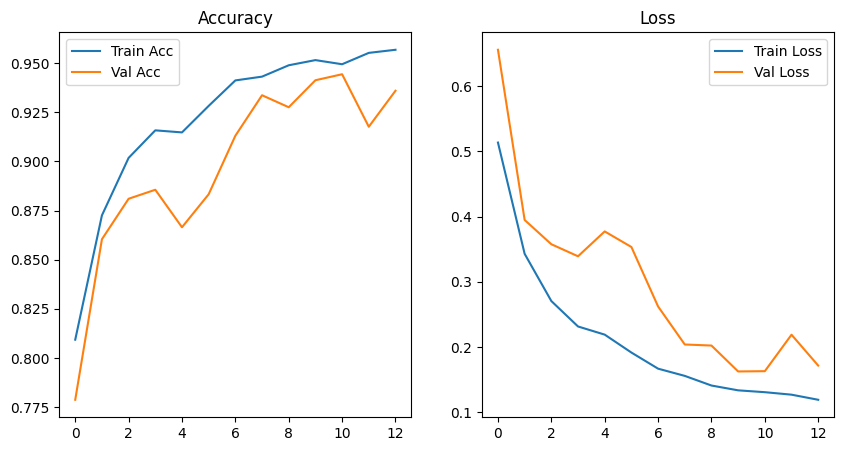

In [36]:
# ================================================================
# 14. PLOTS
# ================================================================
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.show()


## A. Save your MobileNetV2 model

Add this AFTER training:

In [39]:
model.save("best_mobilenetv2.keras")

## B. Save your 128-dim Feature Extractor

Add this AFTER defining feature_extractor:

In [42]:
feature_extractor.save("feature_extractor.keras")

## C. Save your SVM model

Add this after training the SVM:

In [45]:
import joblib
joblib.dump(svm_clf, "svm_model.pkl")

['svm_model.pkl']

## D. Save label map

Add this once:

In [48]:
np.save("label_map.npy", train_gen.class_indices)